cuda
1.13.0+cu117


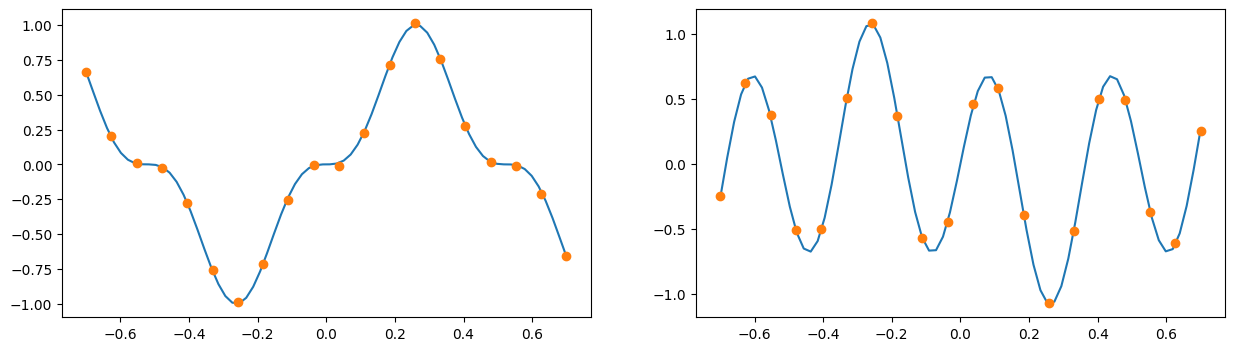

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from collections import OrderedDict
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.__version__)

x = sp.symbols('x')
u = sp.sin(6*x)**3
u_x = sp.diff(u, x)
u_xx = sp.diff(u_x, x)
u_xx = sp.lambdify(x, u_xx, 'numpy')

lam = 0.01
k = 0.7

x = np.linspace(-0.7, 0.7, 70)
u = (np.sin(6*x))**3
f = lam * u_xx(x) # + k*np.tanh(u)

n_train = 20
X_f_train = np.linspace(-0.7, 0.7, n_train)
u_f = (np.sin(6*X_f_train))**3
f_train = lam * u_xx(X_f_train) # + k*np.tanh(u_f)

X_u_train = np.linspace(-0.7, 0.7, n_train)
# X_u_train = np.array([-0.7, 0.7])
u_train = (np.sin(6*X_u_train))**3

noise = 0.01
f_train += noise*np.random.randn(n_train)
u_train += noise*np.random.randn(n_train)

fig, axs = plt.subplots(1, 2, figsize = (15,4))
axs[0].plot(x, u)
axs[0].plot(X_u_train, u_train, 'o')
axs[1].plot(x, f)
axs[1].plot(X_f_train, f_train, 'o')

x = x[:, None]; X_f_train = X_f_train[:, None]
f = f[:, None]; f_train = f_train[:, None]
X_u_train = X_u_train[:, None]
u_train = u_train[:, None]
u = u[:, None]



In [35]:
class DNN(nn.Module):
    def __init__(self, layers):
        super().__init__()

        n_hidden = len(layers) 
        self.activation = nn.Tanh
        layer_list = []

        for i in range(n_hidden-2):

            linear = torch.nn.Linear(layers[i], layers[i+1])

            nn.init.xavier_normal_(linear.weight.data, gain=1.0)
            nn.init.zeros_(linear.bias.data)

            layer_list.append(
                ('layer_%d' % i, linear)
            )
            layer_list.append(
                ('activation_%d' % i, self.activation())
            )
        
        linear = torch.nn.Linear(layers[n_hidden-2], layers[n_hidden-1])
        nn.init.xavier_normal_(linear.weight.data, gain=1.0)
        nn.init.zeros_(linear.bias.data)

        layer_list.append(('layer_%d' % (n_hidden-2), linear))
        
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [36]:
class PINN_Poisson:
    
    def __init__(self, net, X_u, X_f, U, F, lb, ub, device):
        
        # data
        self.X_u = X_u; self.X_f = X_f; self.U = U; self.F = F
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)

        # net
        self.net = net.to(device)
        
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)  
        self.net.register_parameter('lambda_1', self.lambda_1)
      

        # opt: using both Adam and LBFGS
        self.opt_LBFGS = optim.LBFGS(
            self.net.parameters(), 
            lr=1., 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.iter = 0
        self.opt_Adam = optim.Adam(self.net.parameters(), lr=0.003)

    def net_U(self, x):
        x = 2*(x-self.lb)/(self.ub-self.lb) - 1
        u = self.net(x)
        return u

    def net_F(self, x):
        lambda_1 = self.lambda_1        
        # lambda_2 = torch.exp(self.lambda_2)

        u = self.net_U(x)

        u_x = torch.autograd.grad(u, x, torch.ones_like(u), 
                                    retain_graph=True,
                                    create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x),
                                    retain_graph=True,
                                    create_graph=True)[0]
      
        return lambda_1*u_xx

    def _train_step(self):
        
        X_u = torch.tensor(self.X_u, requires_grad=True).float().to(device)
        X_f = torch.tensor(self.X_f, requires_grad=True).float().to(device)
        U = torch.tensor(self.U).float().to(device)
        F = torch.tensor(self.F).float().to(device)
        
        u_pred = self.net_U(X_u)
        f_pred = self.net_F(X_f)
        loss = torch.mean((U-u_pred)**2) + torch.mean((f_pred-F)**2)

        return loss

    def _closure(self):
        loss = self._train_step()
        self.opt_LBFGS.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 200 == 0:
            print('epoch: {}  loss: {:.3e}  lam_1: {:4f}  lam_2: {:.6f}'.format(self.iter, 
                                                                                loss.item(),
                                                                                self.lambda_1.item(),
                                                                                0))
        return loss

    def train(self, epochs):
        self.net.train() # training mode
        for epoch in range(epochs):
            
            loss = self._train_step() 
            
            self.opt_Adam.zero_grad()
            loss.backward()
            self.opt_Adam.step()

            if (epoch+1) % 200 == 0:
                print('epoch: {}  loss: {:.3e}  lam_1: {:4f}  lam_2: {:.6f}'.format(epoch+1, 
                                                                                    loss.item(),
                                                                                    self.lambda_1.item(),
                                                                                    torch.exp(self.lambda_2).item()))
        self.opt_LBFGS.step(self._closure)

    def predict(self, x):
        
        x = torch.tensor(x, requires_grad=True).float().to(device)
    
        self.net.eval()
       
        u_pred = self.net_U(x)
        f_pred = self.net_F(x)
        
        return u_pred.detach().cpu().numpy(), f_pred.detach().cpu().numpy()
        




In [37]:
nu = 0.01/np.pi

N_u = 2000
layers = [1, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# Domain bounds of x, t
lb = x.min(0)
ub = x.max(0) 

net = DNN(layers)
net


DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=1, out_features=20, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=20, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=20, out_features=20, bias=True)
    (activation_4): Tanh()
    (layer_5): Linear(in_features=20, out_features=20, bias=True)
    (activation_5): Tanh()
    (layer_6): Linear(in_features=20, out_features=20, bias=True)
    (activation_6): Tanh()
    (layer_7): Linear(in_features=20, out_features=20, bias=True)
    (activation_7): Tanh()
    (layer_8): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [38]:
pinn = PINN_Poisson(net, X_u_train, X_f_train, u_train, f_train, lb, ub, device)
pinn.train(100) 

epoch: 200  loss: 5.511e-02  lam_1: 0.010481  lam_2: 0.000000
epoch: 400  loss: 3.202e-02  lam_1: 0.010851  lam_2: 0.000000
epoch: 600  loss: 6.971e-03  lam_1: 0.010119  lam_2: 0.000000
epoch: 800  loss: 1.861e-03  lam_1: 0.010310  lam_2: 0.000000
epoch: 1000  loss: 7.524e-04  lam_1: 0.010219  lam_2: 0.000000
epoch: 1200  loss: 3.491e-04  lam_1: 0.010139  lam_2: 0.000000


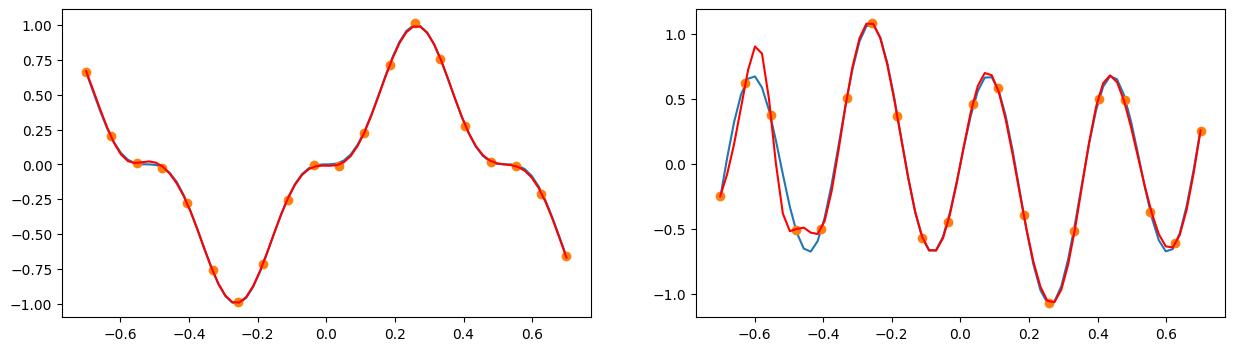

In [39]:
u_pred, f_pred = pinn.predict(x)

fig, axs = plt.subplots(1, 2, figsize = (15,4))
axs[0].plot(x, u)
axs[0].plot(X_u_train, u_train, 'o')
axs[0].plot(x, u_pred, 'r-')
axs[1].plot(x, f)
axs[1].plot(X_f_train, f_train, 'o')
axs[1].plot(x, f_pred, 'r-')
